In [1]:
import os
import gc
import csv
import sys
import time
import h5py
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import nibabel as nib
# from nilearn import image, surface, plotting, datasets

from sklearn.metrics import pairwise_distances
import scipy.sparse as sps
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from scipy.stats import pearsonr
import pickle 

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['ps.usedistiller'] = 'xpdf'
from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

In [2]:
_ = np.array([0, 2, 12, 14, 16, 18, 20, 22, 24, 26, 29, 31, 33, 35, 37, 39, 41, 43, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 4, 5, 6, 7, 8, 9, 10, 11, 28, 45])
# read the fiber name
l_idx = [1,3,13,15,17,19,25,27,30,32,36,38,40,42,44,47,49,51,53,55,57,59,61,63,65,67,69,71]
r_idx = [2,4,14,16,18,24,26,28,31,35,37,39,41,43,45,48,50,52,54,56,58,60,62,64,66,68,70,72]
m_idx = [4,5,6,7,8,9,10,11]
l_idx = np.array(l_idx)
r_idx = np.array(r_idx)
m_idx = np.array(m_idx)
l_idx = l_idx-1
r_idx = r_idx-1
label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum_nohemi.txt', 'r')
label_name = label_f.readlines()
label_name = [' '.join([i.strip() for i in price.strip().split('\n')]) for price in label_name]
label_name_lm = [label_name[l_idx[i]] for i in range(len(l_idx))] + [label_name[m_idx[i]] for i in range(len(m_idx))]
print(f'the number of fiber: {len(label_name_lm)}')

new_fiber_idx = []
for fi,ff in enumerate(_):
    if ff in list(l_idx)+list(m_idx): new_fiber_idx.append(fi)
new_fiber_idx = np.array(new_fiber_idx)
print(new_fiber_idx.shape)

the number of fiber: 36
(36,)


In [3]:
# the medial wall
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# Figure 3D.

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import scipy.sparse as sps
from scipy import sparse
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 
from matplotlib.pyplot import MultipleLocator
# import statsmodels.api as sm
# from nilearn import image, surface, plotting, datasets
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.linear_model import Lasso,Ridge
from sklearn.kernel_ridge import KernelRidge
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

The behavior compoment is from https://github.com/ThomasYeoLab/Ooi2022_MMP_HCP



In [3]:
beh = pd.read_csv('/n01dat01/dyli/multi/HCP-beh/MMP_HCP_componentscores.csv')
beh

,Subject,varimax_satisf,varimax_cog,varimax_er
0,100206,2.517109,1.776892,-1.624746
1,100307,0.450086,0.609260,1.122902
2,100408,-0.449043,2.015609,-0.595095
3,100610,-1.005397,5.149529,2.335381
4,101006,0.349094,-2.776164,-1.482455
...,...,...,...,...
1017,992774,-0.946702,-1.652816,0.977374
1018,993675,-0.067222,4.439379,0.751211
1019,994273,1.288708,-0.739095,-2.191308
1020,995174,1.878596,-2.137252,3.003147


The KRR train model is from https://github.com/ThomasYeoLab/Ooi2022_MMP_HCP

ref link: https://doi.org/10.1016/j.neuroimage.2022.119636

ref title: Comparison of individualized behavioral predictions across anatomical, diffusion and functional connectivity MRI

We found the model which has the best performance.

In [93]:
exp_name = 1200
model_name = 'KRR'

# read the sublist
list_path = '/n02dat01/users/dyli/HCP1200/scripts/HCP_968.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
namelist = namelist[0:900]
namelist_df = pd.DataFrame(namelist, columns=['Subject'], dtype=np.float32)

# train for each behavior
beh_name_list = beh.columns[1:]
for i,beh_name in enumerate(beh_name_list):
    for sigma in [1,2,3,4,5,6,7,8,8,10]:
        for alpha in [1,5,10,20,50,100,200,500]:
            y_pred_df = pd.read_csv(f'/n01dat01/dyli/multi/results_data/HCP_{exp_name}_predict_58beh_PCAComp_{model_name}_alpha{alpha}_sigma{sigma}.csv')
            y_pred = y_pred_df.values[:, 1:]
            y_pred_dict = {}
            y_true = np.zeros((y_pred.shape[0],3))
            corr_plot = np.zeros((3,2))
            # read the y data
            beh = pd.read_csv('/n01dat01/dyli/multi/HCP-beh/MMP_HCP_componentscores.csv')
            _pred = beh.loc[:,['Subject', beh_name]] # choose one behavior
            beh_ = pd.merge(namelist_df, _pred)
            y = np.squeeze(np.array(beh_.loc[:,[beh_name]])) # (40,)
            y_true[:, i] = y
            r,p = pearsonr(y, y_pred[:, i])
            # print(beh_name, sigma, alpha, r,p)
            if beh_name == 'varimax_satisf':
                if r>0.13: print(beh_name, sigma, alpha, r,p)
            elif beh_name == 'varimax_cog':
                if r>0.24: print(beh_name, sigma, alpha, r,p)
            elif beh_name == 'varimax_er':
                if r>0.15: print(beh_name, sigma, alpha, r,p)
            corr_plot[i,0] = r
            corr_plot[i,1] = p
    print('-'*20)

varimax_satisf 2 1 0.13365266537029546 5.769006454971589e-05
--------------------
varimax_cog 3 5 0.24183204738947064 1.9191923697060965e-13
varimax_cog 3 10 0.24008413321385205 2.887614219468929e-13
varimax_cog 4 5 0.24105057451232273 2.304699954033269e-13
varimax_cog 4 10 0.24183356685344956 1.9185082311170194e-13
--------------------
varimax_er 3 200 0.15194910788381705 4.677632914158015e-06
varimax_er 3 500 0.15342430344418234 3.768938280659274e-06
varimax_er 4 100 0.15247262442009724 4.333476686517209e-06
varimax_er 4 200 0.15560625837742972 2.728078085724527e-06
varimax_er 4 500 0.15751440669090594 2.048929867375839e-06
varimax_er 5 200 0.15202536938122582 4.625921113820863e-06
varimax_er 5 500 0.15392722883468052 3.4997522850998435e-06
--------------------


In [4]:
exp_name = 1200
model_name = 'KRR'

# read the sublist
list_path = '/n02dat01/users/dyli/HCP1200/scripts/HCP_968.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
namelist = namelist[0:900]
namelist_df = pd.DataFrame(namelist, columns=['Subject'], dtype=np.float32)

# train for each behavior
beh_name_list = beh.columns[1:]
corr_plot = np.zeros((3,2))
y_pred_dict = {}
y_true = np.zeros((900,3))
for i,beh_name in enumerate(beh_name_list):
    if beh_name == 'varimax_satisf':
        alpha=1
        sigma=2
    elif beh_name == 'varimax_cog':
        alpha=5
        sigma=3
    elif beh_name == 'varimax_er':
        alpha=200
        sigma=4
    y_pred_df = pd.read_csv(f'/n01dat01/dyli/multi/results_data/HCP_{exp_name}_predict_58beh_PCAComp_{model_name}_alpha{alpha}_sigma{sigma}.csv')
    y_pred = y_pred_df.values[:, 1:]
    # read the y data
    beh = pd.read_csv('/n01dat01/dyli/multi/HCP-beh/MMP_HCP_componentscores.csv')
    _pred = beh.loc[:,['Subject', beh_name]] # choose one behavior
    beh_ = pd.merge(namelist_df, _pred)
    y = np.squeeze(np.array(beh_.loc[:,[beh_name]])) # (40,)
    y_true[:, i] = y
    r,p = pearsonr(y, y_pred[:, i])
    print(beh_name, sigma, alpha, r,p)
    corr_plot[i,0] = r
    corr_plot[i,1] = p

varimax_satisf 2 1 0.13365266537029546 5.769006454971589e-05
varimax_cog 3 5 0.24183204738947064 1.9191923697060965e-13
varimax_er 4 200 0.15560625837742972 2.728078085724527e-06


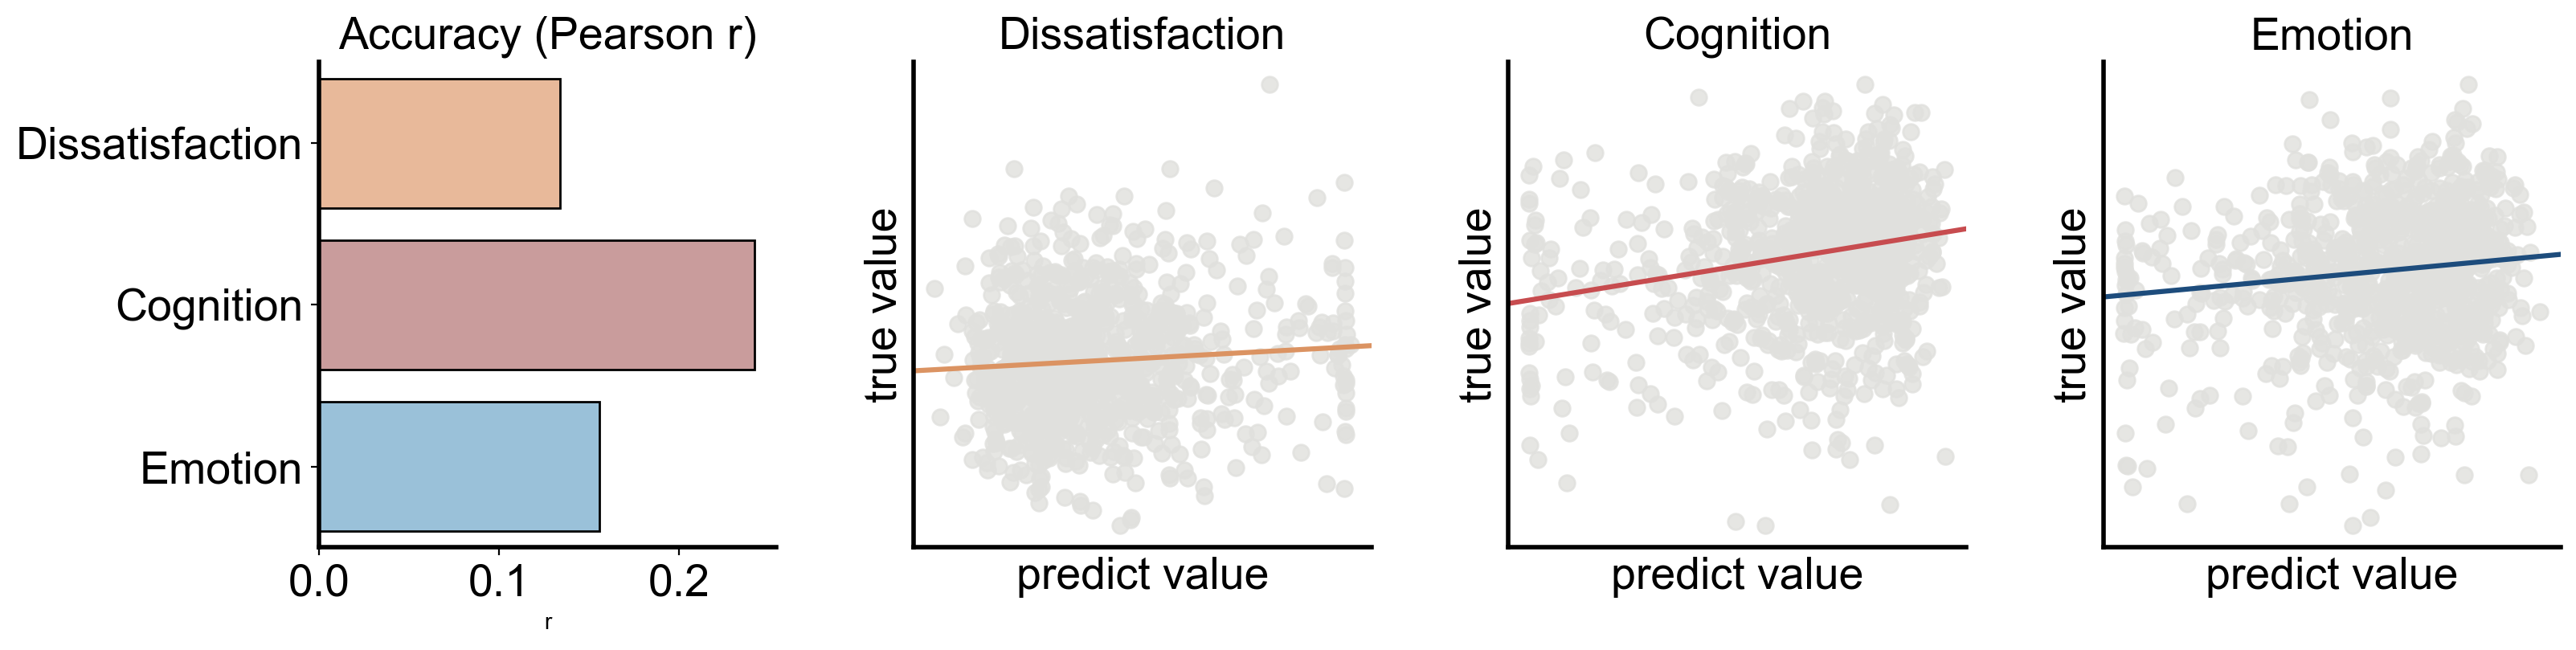

In [6]:
surface_name = 'white'

beh_list = beh.columns[1:]
# beh_name = ['Dis', 'Cog', 'Emo']
beh_name = ['Dissatisfaction', 'Cognition', 'Emotion']
#   (1) cognition, (2) life dissatisfaction and (3) emotional recognition. 
# color_list = ['#508ab2', '#f0bb41', '#b36a6f', '#a1d0c7']
# color_list = ['#508ab2', '#f0bb41', '#b36a6f', '#017d6f']
color_list = ['#f6e3a3', '#F0BB41', '#f5bf5a'] # Yellow
color_list_light = ['#f5b68d', '#d19494', '#8fc3e4']
color_list_dark  = ['#db9362', '#c74c4f', '#1d4c7c']

fig = plt.figure(figsize=(18, 4), dpi=200)
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.3)

ax1 = fig.add_subplot(141)
# plotting
df_ii = pd.DataFrame(columns=['beh name', 'r', 'p'])
palette_light_ii = []
palette_dark_ii = []
for _i in range(3):
    df_ii.loc[len(df_ii.index)] = [beh_name[_i], corr_plot[_i,0], corr_plot[_i,1]]
    palette_light_ii.append(color_list_light[_i])
    palette_dark_ii.append(color_list_dark[_i])

ax1 = sns.barplot(data=df_ii,x='r',y='beh name', # hue='feature_name',
                palette=palette_light_ii,
                estimator=np.mean,
                ci="sd", # capsize=.1,errwidth=1,errcolor="k",
                ax=ax1,
                **{"edgecolor":"k","linewidth":1})
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax1=plt.gca()
x_major_locator=MultipleLocator(0.1)
ax1.xaxis.set_major_locator(x_major_locator)
plt.title('Accuracy (Pearson r)', fontsize=20)
plt.ylabel('')
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth('2.0')
ax1.spines['left'].set_linewidth('2.0')

for behi, beh_name1 in enumerate(beh_list):
    if behi==0 : ax1 = fig.add_subplot(142)
    if behi==1 : ax1 = fig.add_subplot(143)
    if behi==2 : ax1 = fig.add_subplot(144)

    tips1 = pd.DataFrame(np.concatenate([y_true[:,behi][:,np.newaxis], y_pred[:,behi][:,np.newaxis]], axis=1), columns=['true', 'pred'])
    fig = sns.regplot(x="pred", y="true", \
            data=tips1, ci=None,robust=True, \
            scatter_kws={'s':50, 'color':'#e0e0dd'}, \
            line_kws={'linestyle':'solid', 'color':palette_dark_ii[behi]}, \
            # line_kws={'linestyle':'solid', 'color':'black'}, \
            marker='o', truncate=False,
            # color=palette_ii[beh_i-1]
            # color='blue'
            )
    ax1 = plt.gca()

    # # change the y ticks
    # y_major_locator = MultipleLocator(1)
    # ax1.yaxis.set_major_locator(y_major_locator)
    # # change the x ticks
    # x_major_locator = MultipleLocator(1)
    # ax1.xaxis.set_major_locator(x_major_locator)

    plt.title(f'{beh_name[behi]}', fontsize=20)
    plt.yticks([],fontsize=20) 
    plt.xticks([],fontsize=20)
    plt.ylabel('true value', fontsize=20)
    plt.xlabel('predict value', fontsize=20)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_linewidth('2.0')
    ax1.spines['left'].set_linewidth('2.0')
    fig = fig.get_figure()
plt.show()
plt.close()

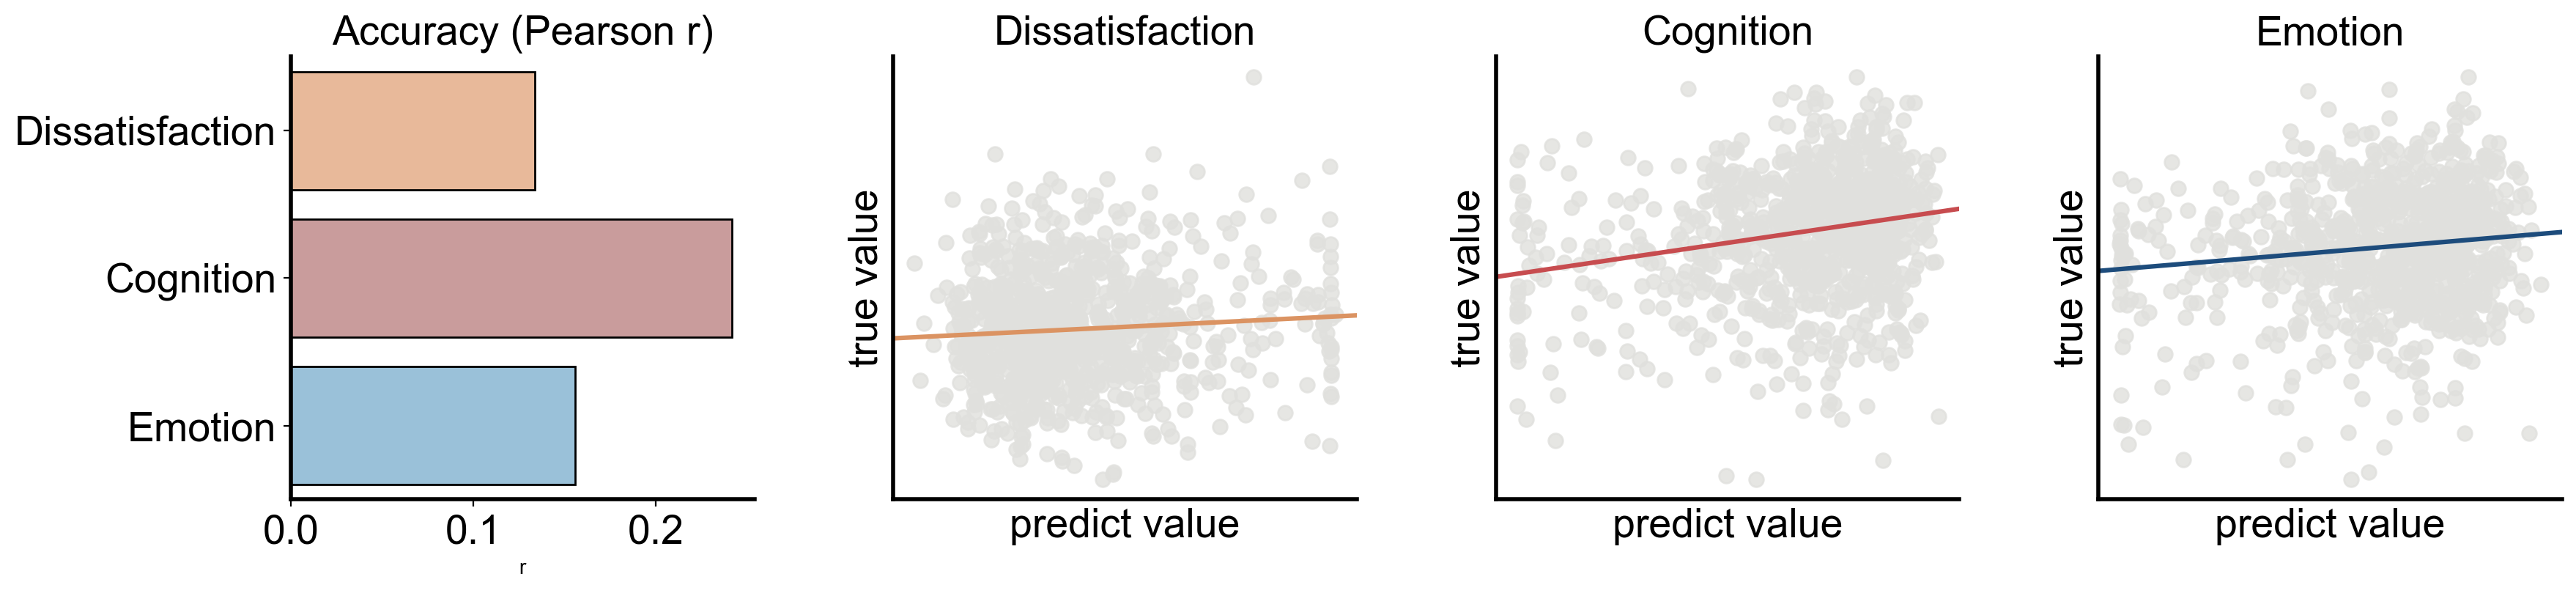

In [11]:
surface_name = 'white'

beh_list = beh.columns[1:]
# beh_name = ['Dis', 'Cog', 'Emo']
beh_name = ['Dissatisfaction', 'Cognition', 'Emotion']
#   (1) cognition, (2) life dissatisfaction and (3) emotional recognition. 
# color_list = ['#508ab2', '#f0bb41', '#b36a6f', '#a1d0c7']
# color_list = ['#508ab2', '#f0bb41', '#b36a6f', '#017d6f']
color_list = ['#f6e3a3', '#F0BB41', '#f5bf5a'] # Yellow
color_list_light = ['#f5b68d', '#d19494', '#8fc3e4']
color_list_dark  = ['#db9362', '#c74c4f', '#1d4c7c']

fig = plt.figure(figsize=(20, 4), dpi=200)
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.3)

ax1 = fig.add_subplot(141)
# plotting
df_ii = pd.DataFrame(columns=['beh name', 'r', 'p'])
palette_light_ii = []
palette_dark_ii = []
for _i in range(3):
    df_ii.loc[len(df_ii.index)] = [beh_name[_i], corr_plot[_i,0], corr_plot[_i,1]]
    palette_light_ii.append(color_list_light[_i])
    palette_dark_ii.append(color_list_dark[_i])

ax1 = sns.barplot(data=df_ii,x='r',y='beh name', # hue='feature_name',
                palette=palette_light_ii,
                estimator=np.mean,
                ci="sd", # capsize=.1,errwidth=1,errcolor="k",
                ax=ax1,
                **{"edgecolor":"k","linewidth":1})
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax1=plt.gca()
x_major_locator=MultipleLocator(0.1)
ax1.xaxis.set_major_locator(x_major_locator)
plt.title('Accuracy (Pearson r)', fontsize=20)
plt.ylabel('')
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth('2.0')
ax1.spines['left'].set_linewidth('2.0')

for behi, beh_name1 in enumerate(beh_list):
    if behi==0 : ax1 = fig.add_subplot(142)
    if behi==1 : ax1 = fig.add_subplot(143)
    if behi==2 : ax1 = fig.add_subplot(144)

    tips1 = pd.DataFrame(np.concatenate([y_true[:,behi][:,np.newaxis], y_pred[:,behi][:,np.newaxis]], axis=1), columns=['true', 'pred'])
    fig = sns.regplot(x="pred", y="true", \
            data=tips1, ci=None,robust=True, \
            scatter_kws={'s':50, 'color':'#e0e0dd'}, \
            line_kws={'linestyle':'solid', 'color':palette_dark_ii[behi]}, \
            # line_kws={'linestyle':'solid', 'color':'black'}, \
            marker='o', truncate=False,
            # color=palette_ii[beh_i-1]
            # color='blue'
            )
    ax1 = plt.gca()

    # # change the y ticks
    # y_major_locator = MultipleLocator(1)
    # ax1.yaxis.set_major_locator(y_major_locator)
    # # change the x ticks
    # x_major_locator = MultipleLocator(1)
    # ax1.xaxis.set_major_locator(x_major_locator)

    plt.title(f'{beh_name[behi]}', fontsize=20)
    plt.yticks([],fontsize=20) 
    plt.xticks([],fontsize=20)
    plt.ylabel('true value', fontsize=20)
    plt.xlabel('predict value', fontsize=20)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_linewidth('2.0')
    ax1.spines['left'].set_linewidth('2.0')
    fig = fig.get_figure()
plt.show()
plt.close()

# Figure 3E.

Calculate the weight for each TGC

Ref Link: https://doi.org/10.1016/j.neuroimage.2013.10.067 

Ref title: On the interpretation of weight vectors of linear models in multivariate neuroimaging

In [78]:
exp_name = '1200'
comp_num = 20
fold_num = 10
print(exp_name)

# read the sublist
list_path = '/n02dat01/users/dyli/HCP1200/scripts/HCP_968.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
namelist = namelist[0:900]
namelist_df = pd.DataFrame(namelist, columns=['Subject'], dtype=np.float32)

def normalization(x):
    # x: sub num * feature length
    # normalization along the subject
    for _s in range(x.shape[0]):
        x[_s, :] = (x[_s, :] - np.mean(x[_s, :]))
    return x

# for each behavior
beh_name_list = beh.columns[1:]
for beh_name in beh_name_list:
    # read the y data
    beh = pd.read_csv('/n01dat01/dyli/multi/HCP-beh/MMP_HCP_componentscores.csv')
    _pred = beh.loc[:,['Subject', beh_name]] # choose one behavior
    beh_ = pd.merge(namelist_df, _pred)
    y = np.squeeze(np.array(beh_.loc[:,[beh_name]])) # (40,)

    if ~np.isnan(y).any():
        # read x data: parameter
        x = np.zeros((len(namelist), 200*36))
        for subi,sub in enumerate(namelist):
            para = np.load(f'/n01dat01/dyli/multi/HCP_{exp_name}/{sub}/FP_{sub}_predict_by_200_group_whitemode_deve-mode_para_L.npy')[:, new_fiber_idx]
            x[subi,:] = para.flatten()

        # relationship between x and y
        # feature_important = np.zeros(7200)
        # for fi in tqdm(range(7200)):
        #     feature_important[fi], p = pearsonr(x[:, fi], y)
        # feature_important = np.dot(normalization(x).T , (y - np.mean(y)))
        feature_important = np.dot(normalization(x).T, y-np.mean(y))
        print(feature_important.shape)
        np.savetxt(f'/n01dat01/dyli/multi/results_data/KongRu_PCAbeh_expression/{beh_name}_feature_important_haufe.txt', feature_important)

1200
(7200,)
(7200,)
(7200,)


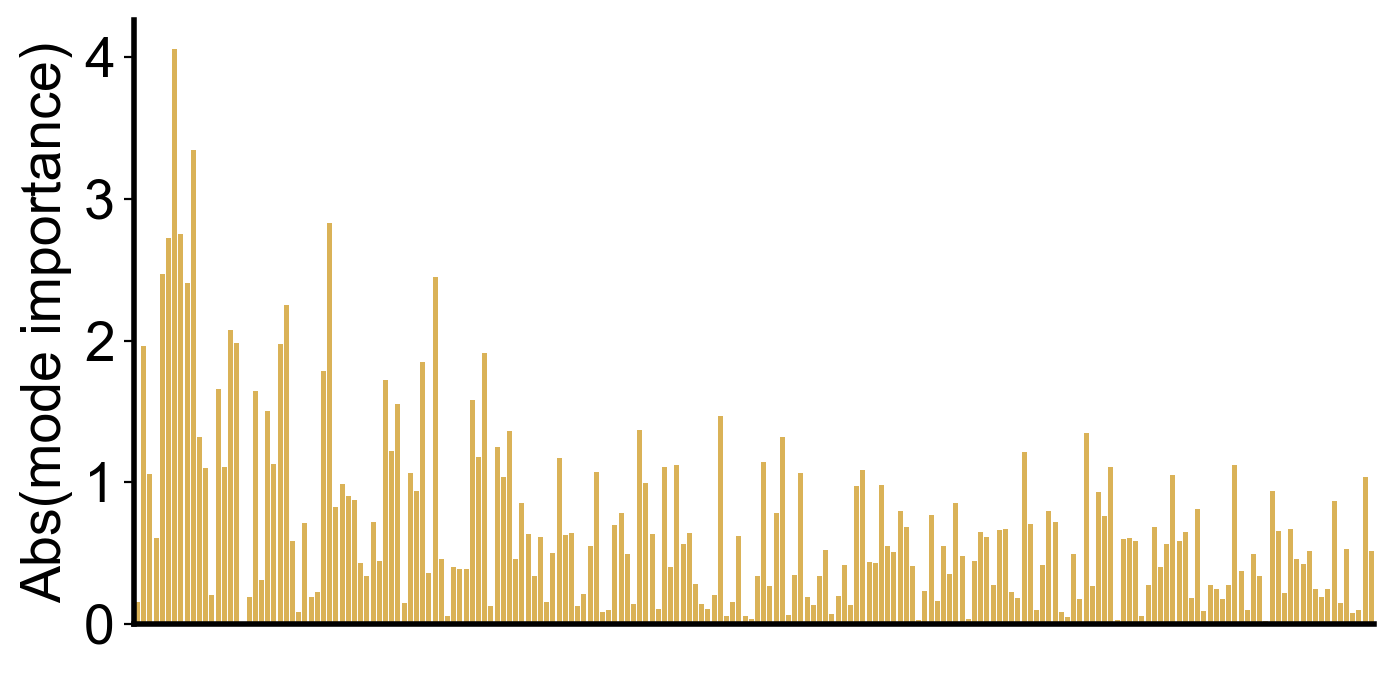

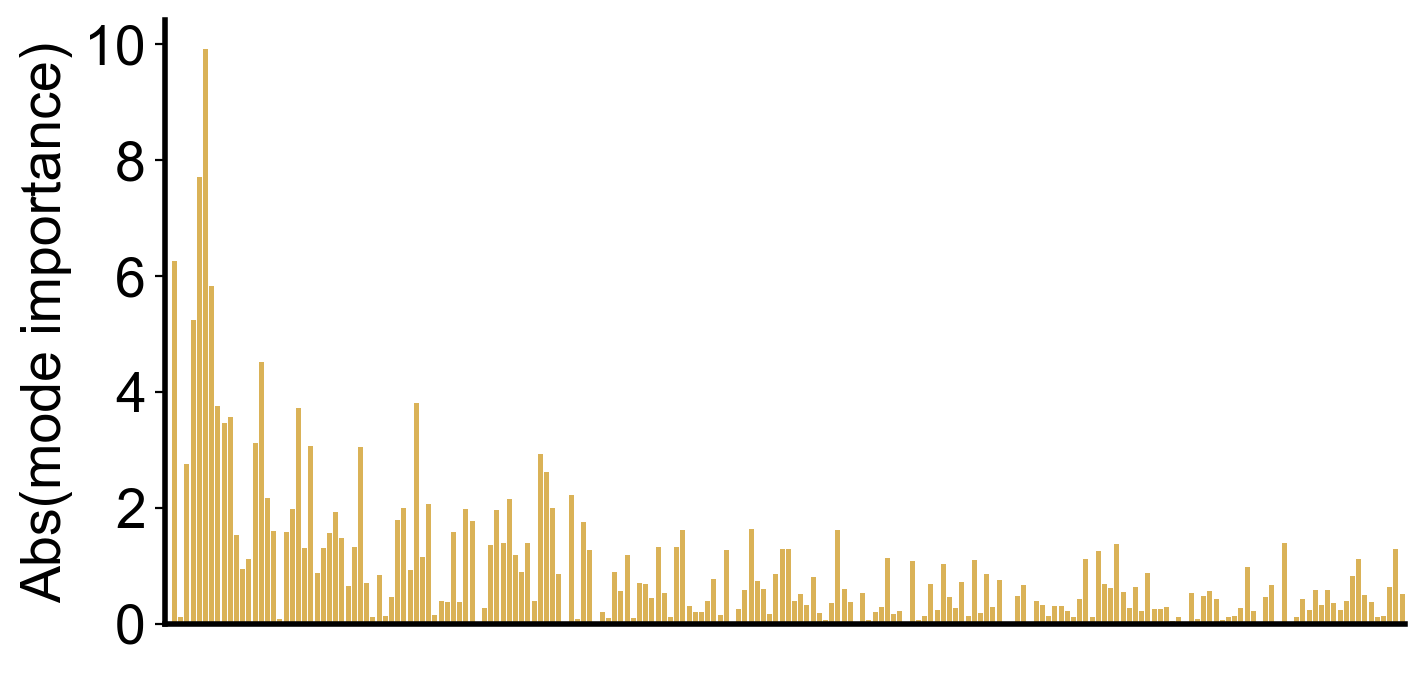

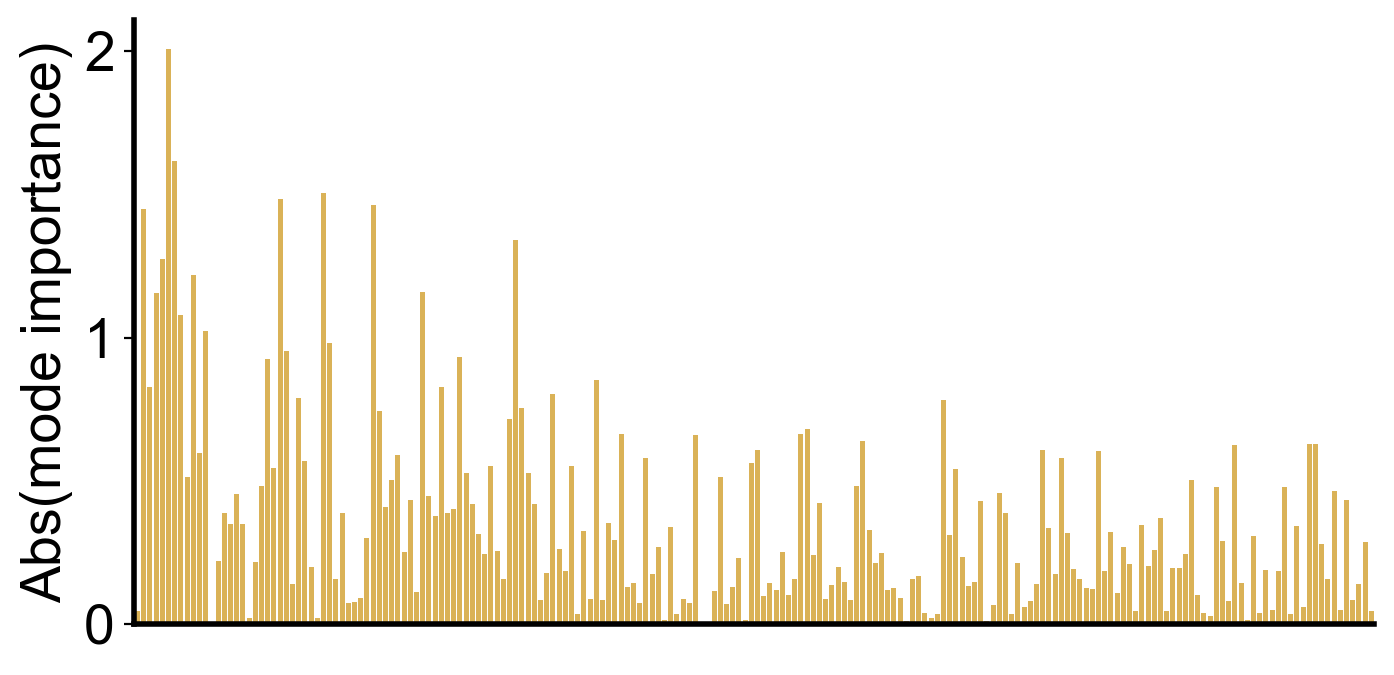

In [6]:
# df = pd.DataFrame(columns=['mode', 'mode contribution', 'beh name'])
for behi, beh_name in enumerate(['varimax_satisf', 'varimax_cog', 'varimax_er']):
    # fig,ax = plt.subplots(figsize=(10,4),dpi=100,facecolor="w")
    fig = plt.figure(figsize=(8, 4), dpi=200)
    fig.subplots_adjust(hspace=0.5)
    # fig.subplots_adjust(wspace=0.3)

    #------------------------------ mode ------------------------------#
    x_weights_ = np.loadtxt(f'/n01dat01/dyli/multi/results_data/KongRu_PCAbeh_expression/{beh_name}_feature_important_haufe.txt').reshape(200, 36)
    x_weights_[np.isnan(x_weights_)] =0

    abs_FLAG=0
    # 按照fiber求和，得到mode的contribution
    if abs_FLAG: x_weights_mode  = np.abs(np.sum(x_weights_, axis=1))
    else: x_weights_mode  = np.sum(x_weights_, axis=1)

    # mode contribution只看绝对值
    x_weights_mode = np.abs(x_weights_mode)

    # color map for mode
    # color_list = ['#508ab2', '#f0bb41', '#b36a6f', '#017d6f']
    color_list = ['#f0bb41', '#f0bb41', '#f0bb41', '#f0bb41']
    palette = [color_list[behi] for i in range(200)]

    df = pd.DataFrame(columns=['mode', 'mode contribution', 'beh name'])
    for ii in range(200):
        #add row to end of DataFrame
        df.loc[len(df.index)] = [ii, x_weights_mode[ii], beh_name]

    ax = fig.add_subplot(111)
    ax = sns.barplot(data=df,y='mode contribution',
                    x='mode', 
                    # hue='beh name',
                    # palette=color_list,
                    palette = palette, 
                    estimator=np.mean, ci="sd", # capsize=.1,errwidth=1,errcolor="k",
                    ax=ax,)
                    # **{"edgecolor":"k","linewidth":1})
    plt.yticks(fontsize=20)
    plt.xticks([],fontsize=20)
    ax=plt.gca()
    if behi ==0:
        y_major_locator=MultipleLocator(1)
        ax.yaxis.set_major_locator(y_major_locator)
    if behi ==2:
        y_major_locator=MultipleLocator(1)
        ax.yaxis.set_major_locator(y_major_locator)
    plt.xlabel('', fontsize=20)
    plt.ylabel('Abs(mode importance)', fontsize=20)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    plt.show()

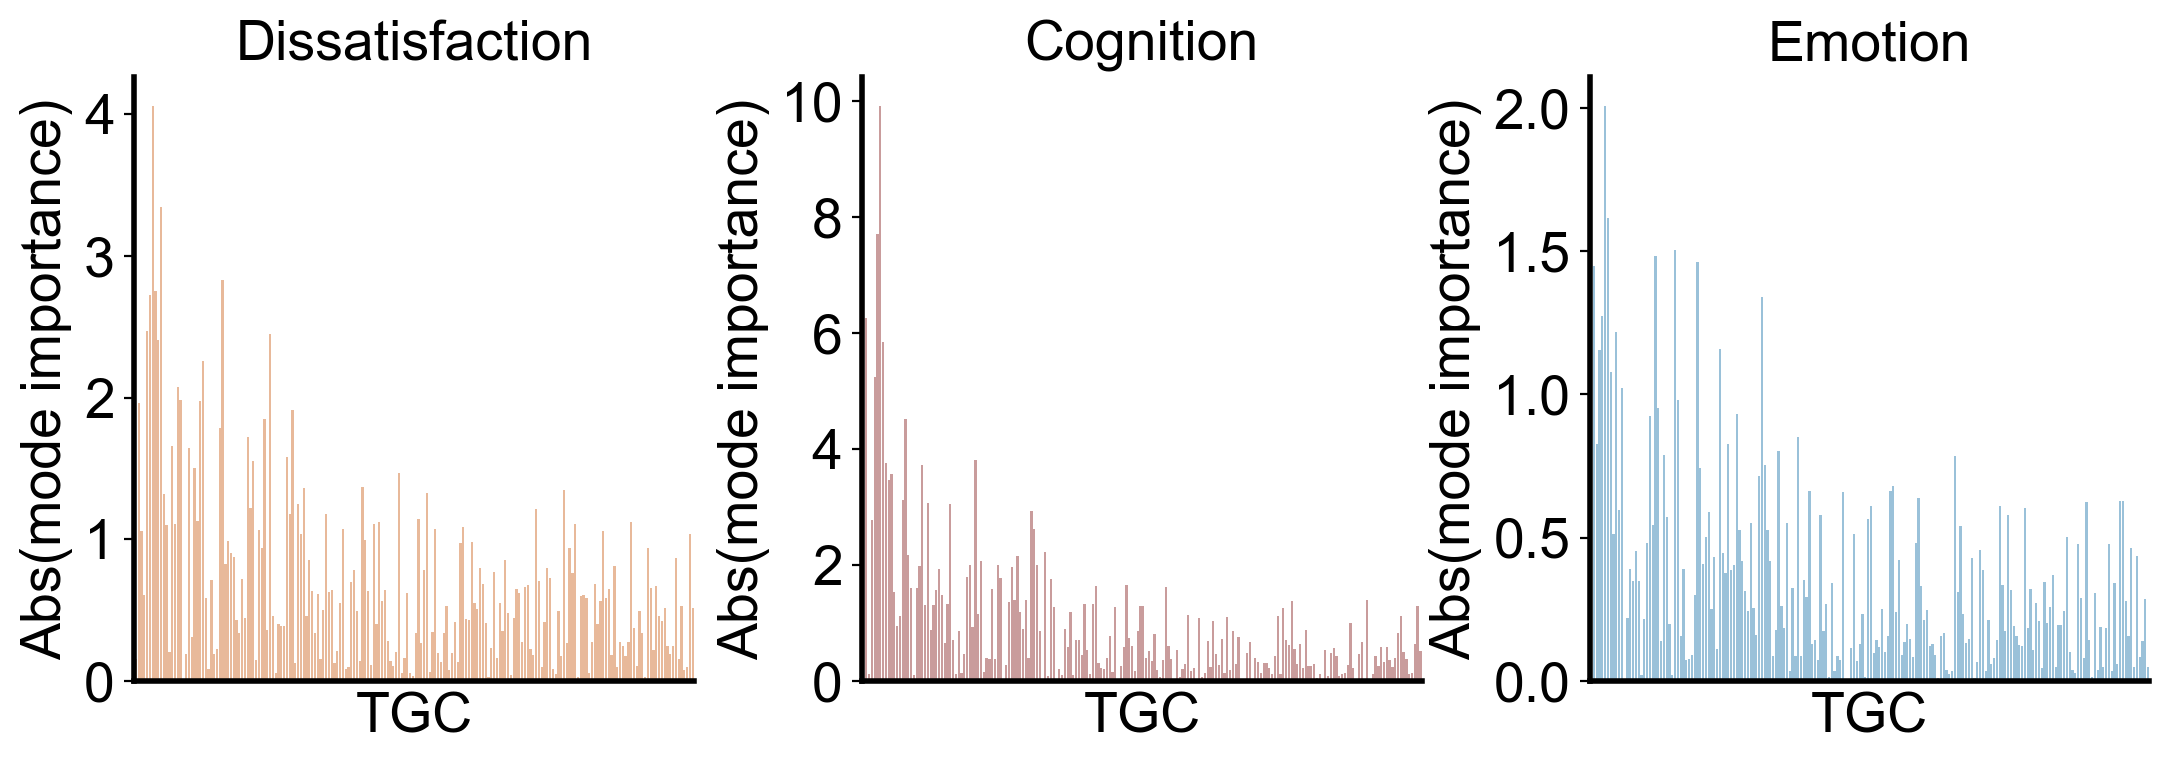

In [30]:
color_list_dark  = ['#db9362', '#c74c4f', '#1d4c7c']
# df = pd.DataFrame(columns=['mode', 'mode contribution', 'beh name'])
fig = plt.figure(figsize=(13, 4), dpi=200)
# fig,ax = plt.subplots(figsize=(10,4),dpi=100,facecolor="w")
# fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.3)
for behi, beh_name in enumerate(['varimax_satisf', 'varimax_cog', 'varimax_er']):

    #------------------------------ mode ------------------------------#
    x_weights_ = np.loadtxt(f'/n01dat01/dyli/multi/results_data/KongRu_PCAbeh_expression/{beh_name}_feature_important_haufe.txt').reshape(200, 36)
    x_weights_[np.isnan(x_weights_)] =0

    abs_FLAG=0
    # 按照fiber求和，得到mode的contribution
    if abs_FLAG: x_weights_mode  = np.abs(np.sum(x_weights_, axis=1))
    else: x_weights_mode  = np.sum(x_weights_, axis=1)

    # mode contribution只看绝对值
    x_weights_mode = np.abs(x_weights_mode)

    # color map for mode
    # color_list = ['#508ab2', '#f0bb41', '#b36a6f', '#017d6f']
    # color_list = ['#f0bb41', '#f0bb41', '#f0bb41', '#f0bb41']
    color_list = ['#db9362', '#c74c4f', '#1d4c7c'] # dark
    color_list = ['#f5b68d', '#d19494', '#8fc3e4'] # light
    palette = [color_list[behi] for i in range(200)]

    df = pd.DataFrame(columns=['mode', 'mode contribution', 'beh name'])
    for ii in range(200):
        #add row to end of DataFrame
        df.loc[len(df.index)] = [ii, x_weights_mode[ii], beh_name]

    if behi==0: ax = fig.add_subplot(131)
    if behi==1: ax = fig.add_subplot(132)
    if behi==2: ax = fig.add_subplot(133)
    ax = sns.barplot(data=df,y='mode contribution',
                    x='mode', 
                    # hue='beh name',
                    # palette=color_list,
                    palette = palette, 
                    estimator=np.mean, ci="sd", # capsize=.1,errwidth=1,errcolor="k",
                    ax=ax,)
                    # **{"edgecolor":"k","linewidth":1})
    plt.yticks(fontsize=20)
    plt.xticks([],fontsize=20)
    ax=plt.gca()
    if behi ==0:
        y_major_locator=MultipleLocator(1)
        ax.yaxis.set_major_locator(y_major_locator)
    if behi ==2:
        y_major_locator=MultipleLocator(0.5)
        ax.yaxis.set_major_locator(y_major_locator)
    plt.xlabel('TGC', fontsize=20)
    plt.ylabel('Abs(mode importance)', fontsize=20)
    if behi==0: plt.title('Dissatisfaction', fontsize=20)
    if behi==1: plt.title('Cognition', fontsize=20)
    if behi==2: plt.title('Emotion', fontsize=20)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
plt.show()

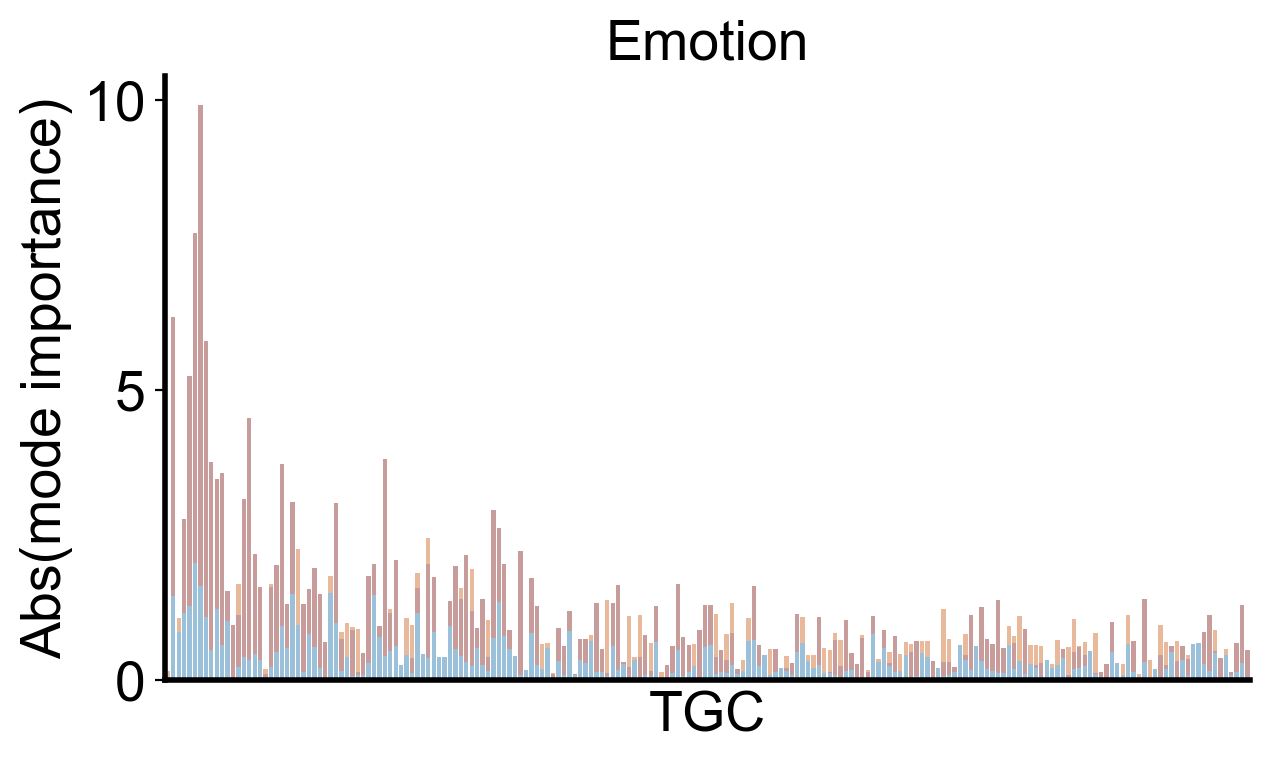

In [10]:
color_list_dark  = ['#db9362', '#c74c4f', '#1d4c7c']
# df = pd.DataFrame(columns=['mode', 'mode contribution', 'beh name'])
fig = plt.figure(figsize=(7, 4), dpi=200)
# fig,ax = plt.subplots(figsize=(10,4),dpi=100,facecolor="w")
# fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.3)
for behi, beh_name in enumerate(['varimax_satisf', 'varimax_cog', 'varimax_er']):

    #------------------------------ mode ------------------------------#
    x_weights_ = np.loadtxt(f'/n01dat01/dyli/multi/results_data/KongRu_PCAbeh_expression/{beh_name}_feature_important_haufe.txt').reshape(200, 36)
    x_weights_[np.isnan(x_weights_)] =0

    abs_FLAG=0
    # 按照fiber求和，得到mode的contribution
    if abs_FLAG: x_weights_mode  = np.abs(np.sum(x_weights_, axis=1))
    else: x_weights_mode  = np.sum(x_weights_, axis=1)

    # mode contribution只看绝对值
    x_weights_mode = np.abs(x_weights_mode)

    # color map for mode
    # color_list = ['#508ab2', '#f0bb41', '#b36a6f', '#017d6f']
    # color_list = ['#f0bb41', '#f0bb41', '#f0bb41', '#f0bb41']
    color_list = ['#db9362', '#c74c4f', '#1d4c7c'] # dark
    color_list = ['#f5b68d', '#d19494', '#8fc3e4'] # light
    palette = [color_list[behi] for i in range(200)]

    df = pd.DataFrame(columns=['mode', 'mode contribution', 'beh name'])
    for ii in range(200):
        #add row to end of DataFrame
        df.loc[len(df.index)] = [ii, x_weights_mode[ii], beh_name]

    if behi==0: ax = fig.add_subplot(111)
    # if behi==1: ax = fig.add_subplot(132)
    # if behi==2: ax = fig.add_subplot(133)
    ax = sns.barplot(data=df,y='mode contribution',
                    x='mode', 
                    # hue='beh name',
                    # palette=color_list,
                    palette = palette, 
                    estimator=np.mean, ci="sd", # capsize=.1,errwidth=1,errcolor="k",
                    ax=ax,)
                    # **{"edgecolor":"k","linewidth":1})
plt.yticks(fontsize=20)
plt.xticks([],fontsize=20)
ax=plt.gca()
y_major_locator=MultipleLocator(5)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('TGC', fontsize=20)
plt.ylabel('Abs(mode importance)', fontsize=20)
if behi==0: plt.title('Dissatisfaction', fontsize=20)
if behi==1: plt.title('Cognition', fontsize=20)
if behi==2: plt.title('Emotion', fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
plt.show()